# Hackaron at INSOFE - Predicting the customer churn in a bank

## Problem Statement:

Long term customers contribute to profitability through mere continued association as they are less costly to serve and through additional services and referrals. It is important to have data that underlies construction of purchase decision and also the underlying loyalty hooks. So a good deal of marketing budget is allocated to engage customer on an 
ongoing basis and prevent churn by designing new plans and offering freebees, discounts 
etc. Thus, it is important to predict the customers who are likely to churn and develop appropriate modalities for retention

An international bank has a business problem with customer retention and observed high 
churn rates. The bank observed that alarming number of existing customers exit while it is 
getting increasingly difficult to acquire new customers. So they want to understand the hidden patterns in their customer behaviour by use of customer data which has early warning 
signs.This helps understand the drivers behind considering an alternative. The variables 
could be demographic, perception or behavioural. 
You are expected to create an analytical and modelling framework to predict the customer 
churn in a bank based on the quantitative and qualitative features provided in the datasets.

Data:
1. train_data.xlsx (to train the model)
2. test_data.xlsx (to predict the Churn)

Objective: 
You are expected to create an analytical and modelling framework to predict the customer Churn: 1 (Yes) / 0 (No); Based on the quantitative and qualitative features provided in the data. 

Evaluation Metric: F1 score for class ‘1’ (Yes) is the evaluation metric for this problem.

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report, recall_score, precision_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn import tree

In [101]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.feature_selection import RFECV
from scipy.cluster.hierarchy import linkage, dendrogram

Read the input file

In [3]:
bank_data = pd.read_excel(r'train_data.xlsx')

In [4]:
bank_data.shape

(7360, 21)

In [5]:
bank_data.head()

,CustomerID,CustomerName,yearofBirth,monthofBirth,dayofBirth,yearofEntry,monthofEntry,dayofEntry,Gender,Location,...,MaritalStatus,Occupation,Ownhouse,CreditScore,AccountBalance,NumberOfProducts,IsCreditCardCustomer,ActiveMember,Salary,Churn
0,C5814651,Name_5814651,1980,5,12,2014,11,28,Male,Location11,...,divorced,management,no,716,0.00,2,1,0,189678.70,0
1,C6465787,Name_6465787,1986,12,28,2011,8,17,Female,Location13,...,divorced,admin.,no,568,169399.60,1,1,0,61936.22,0
2,C3824349,Name_3824349,1999,11,23,2013,12,9,Male,Location13,...,married,unknown,unknown,739,89750.21,1,1,0,193008.52,0
3,C8431888,Name_8431888,1969,4,6,2015,12,12,Female,Location11,...,married,admin.,yes,678,204510.94,1,0,1,738.88,1
4,C2944860,Name_2944860,1993,6,15,2012,10,10,Male,Location13,...,single,management,no,670,0.00,2,1,1,78358.94,0


In [6]:
bank_data.dtypes

CustomerID               object
CustomerName             object
yearofBirth               int64
monthofBirth              int64
dayofBirth                int64
yearofEntry               int64
monthofEntry              int64
dayofEntry                int64
Gender                   object
Location                 object
Education                object
MaritalStatus            object
Occupation               object
Ownhouse                 object
CreditScore               int64
AccountBalance          float64
NumberOfProducts          int64
IsCreditCardCustomer      int64
ActiveMember              int64
Salary                  float64
Churn                     int64
dtype: object

In [7]:
bank_data.isnull().sum()

CustomerID              0
CustomerName            0
yearofBirth             0
monthofBirth            0
dayofBirth              0
yearofEntry             0
monthofEntry            0
dayofEntry              0
Gender                  0
Location                0
Education               0
MaritalStatus           0
Occupation              0
Ownhouse                0
CreditScore             0
AccountBalance          0
NumberOfProducts        0
IsCreditCardCustomer    0
ActiveMember            0
Salary                  0
Churn                   0
dtype: int64

In [8]:
today = datetime.date.today()
type(today)

datetime.date

In [9]:
def dateconversion(df, year, month, date, x):
    bank_data_t1 = df[[year, month, date]].copy()
    bank_data_t1.columns = ["year", "month", "day"]
    bank_data_t1['diff'] = pd.Timestamp.today().normalize()- pd.to_datetime(bank_data_t1[['year','month','day']])
    bank_data_t1['diff'] = (bank_data_t1['diff'].astype('timedelta64[D]')/365).astype(int)  
    df[x] = bank_data_t1['diff']
    return df

In [10]:
# Find the Age and duration of entry
dateconversion(bank_data, "yearofBirth", "monthofBirth", "dayofBirth", "Age")
dateconversion(bank_data, "yearofEntry", "monthofEntry", "dayofEntry", "Entry_Duration")

,CustomerID,CustomerName,yearofBirth,monthofBirth,dayofBirth,yearofEntry,monthofEntry,dayofEntry,Gender,Location,...,Ownhouse,CreditScore,AccountBalance,NumberOfProducts,IsCreditCardCustomer,ActiveMember,Salary,Churn,Age,Entry_Duration
0,C5814651,Name_5814651,1980,5,12,2014,11,28,Male,Location11,...,no,716,0.00,2,1,0,189678.70,0,41,6
1,C6465787,Name_6465787,1986,12,28,2011,8,17,Female,Location13,...,no,568,169399.60,1,1,0,61936.22,0,34,10
2,C3824349,Name_3824349,1999,11,23,2013,12,9,Male,Location13,...,unknown,739,89750.21,1,1,0,193008.52,0,21,7
3,C8431888,Name_8431888,1969,4,6,2015,12,12,Female,Location11,...,yes,678,204510.94,1,0,1,738.88,1,52,5
4,C2944860,Name_2944860,1993,6,15,2012,10,10,Male,Location13,...,no,670,0.00,2,1,1,78358.94,0,28,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7355,C5312907,Name_5312907,1980,12,12,2014,12,14,Female,Location12,...,yes,593,129499.42,1,1,1,154071.27,0,40,6
7356,C5373454,Name_5373454,1951,9,27,2013,2,7,Male,Location13,...,no,796,0.00,2,0,1,54871.02,0,69,8
7357,C6167603,Name_6167603,1958,12,21,2011,2,28,Male,Location11,...,yes,499,76961.60,2,1,1,83643.87,0,62,10
7358,C3300290,Name_3300290,1985,4,28,2012,12,18,Female,Location11,...,yes,685,0.00,2,0,1,186785.01,0,36,8


In [11]:
bank_data.drop(['yearofBirth', 'monthofBirth','dayofBirth', 'yearofEntry', 'monthofEntry', 'dayofEntry','CustomerName', 'CustomerID' ], axis = 1, inplace = True)

In [12]:
bank_data.dtypes

Gender                   object
Location                 object
Education                object
MaritalStatus            object
Occupation               object
Ownhouse                 object
CreditScore               int64
AccountBalance          float64
NumberOfProducts          int64
IsCreditCardCustomer      int64
ActiveMember              int64
Salary                  float64
Churn                     int64
Age                       int32
Entry_Duration            int32
dtype: object

In [13]:
for i in bank_data.columns:
    print(i, ": The number of unique", bank_data[i].nunique() )

Gender : The number of unique 2
Location : The number of unique 3
Education : The number of unique 4
MaritalStatus : The number of unique 3
Occupation : The number of unique 7
Ownhouse : The number of unique 3
CreditScore : The number of unique 449
AccountBalance : The number of unique 4706
NumberOfProducts : The number of unique 4
IsCreditCardCustomer : The number of unique 2
ActiveMember : The number of unique 2
Salary : The number of unique 7359
Churn : The number of unique 2
Age : The number of unique 71
Entry_Duration : The number of unique 12


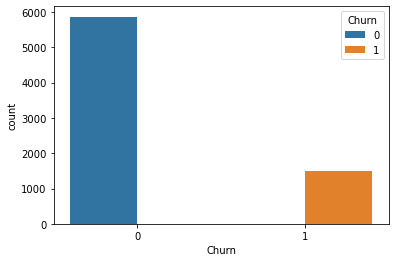

In [168]:
# Plot Distribution
sns.countplot(x='Churn',hue = 'Churn', data=bank_data)
plt.show()

In [169]:
print(bank_data.Churn.value_counts())

count_yes = len(bank_data[bank_data.Churn == 1])
count_no = len(bank_data[bank_data.Churn != 1])

percent_success = (count_yes/(count_yes + count_no))*100

print('Percentage of customer churn in a bank:', percent_success, "%")

0    5868
1    1492
Name: Churn, dtype: int64
Percentage of customer churn in a bank: 20.27173913043478 %


Male      3994
Female    3366
Name: Gender, dtype: int64


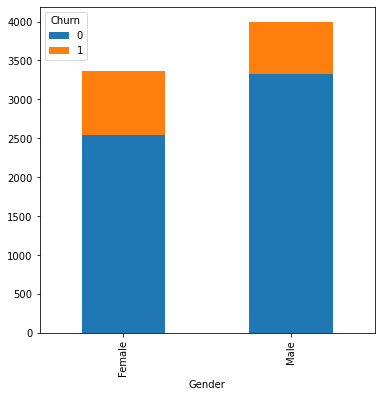

In [170]:
print(bank_data.Gender.value_counts())
ct = pd.crosstab(bank_data['Gender'], bank_data['Churn'])
ct.plot.bar(figsize = (6, 6), stacked=True)
plt.legend(title='Churn')
plt.show()

Inference : There are almost equal number of male and female customer. More number of female customer are about to churn.

Location11    3693
Location12    1834
Location13    1833
Name: Location, dtype: int64


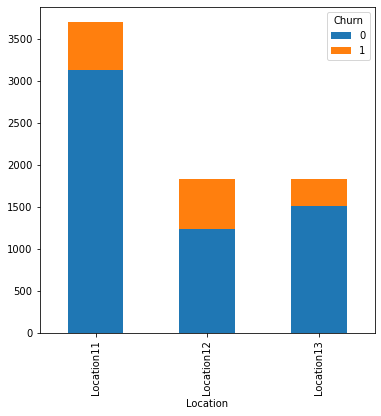

In [171]:
print(bank_data.Location.value_counts())
ct = pd.crosstab(bank_data['Location'], bank_data['Churn'])
ct.plot.bar(figsize = (6, 6), stacked=True)
plt.legend(title='Churn')
plt.show()

Inference: Number of customers from Location11 are double that of Location12 and Location13. Churn rate is lower in location Location13.

primary      1864
unknown      1860
secondary    1839
tertiary     1797
Name: Education, dtype: int64


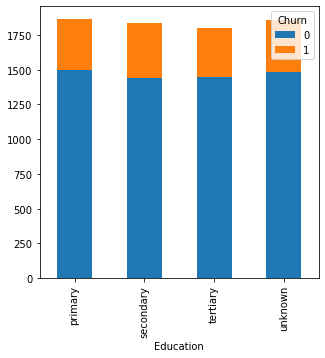

In [172]:
print(bank_data.Education.value_counts())
ct = pd.crosstab(bank_data['Education'], bank_data['Churn'])
ct.plot.bar(figsize = (5, 5), stacked=True)
plt.legend(title='Churn')
plt.show()

Inference : Customer with different educational background have got same churn rate. 

single      2559
married     2503
divorced    2298
Name: MaritalStatus, dtype: int64


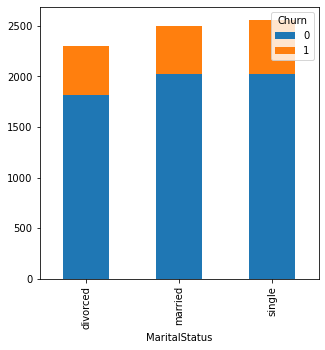

In [173]:
print(bank_data.MaritalStatus.value_counts())
ct = pd.crosstab(bank_data['MaritalStatus'], bank_data['Churn'])
ct.plot.bar(figsize = (5, 5), stacked=True)
plt.legend(title='Churn')
plt.show()

admin.           3207
unknown           781
technician        770
services          762
management        749
self-employed     748
retired           343
Name: Occupation, dtype: int64


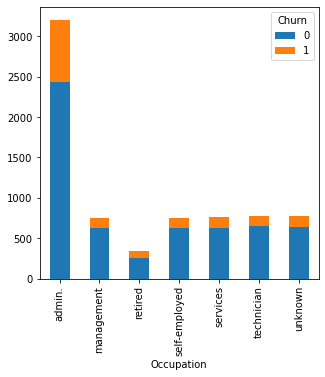

In [174]:
print(bank_data.Occupation.value_counts())
ct = pd.crosstab(bank_data['Occupation'], bank_data['Churn'])
ct.plot.bar(figsize = (5, 5), stacked=True)
plt.legend(title='Churn')
plt.show()

Inference: There are least number of retired customers, highest number of customers belong to admin. Churn rate is hightest in admin customer.

no         3684
yes        3485
unknown     191
Name: Ownhouse, dtype: int64


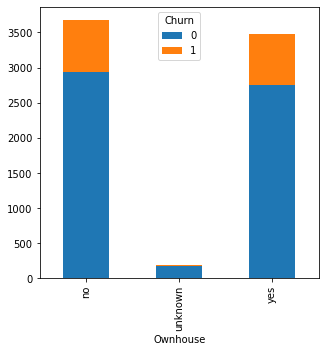

In [175]:
print(bank_data.Ownhouse.value_counts())
ct = pd.crosstab(bank_data['Ownhouse'], bank_data['Churn'])
ct.plot.bar(figsize = (5, 5), stacked=True)
plt.legend(title='Churn')
plt.show()

1    3768
2    3363
3     189
4      40
Name: NumberOfProducts, dtype: int64


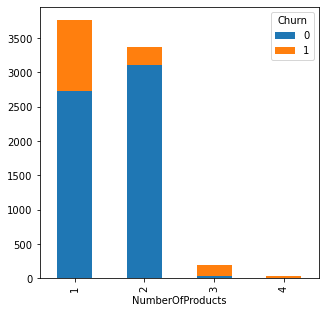

In [176]:
print(bank_data.NumberOfProducts.value_counts())
ct = pd.crosstab(bank_data['NumberOfProducts'], bank_data['Churn'])
ct.plot.bar(figsize = (5, 5), stacked=True)
plt.legend(title='Churn')
plt.show()

Inference : Product1 has large number of churn rate compared to rest.

1    5183
0    2177
Name: IsCreditCardCustomer, dtype: int64


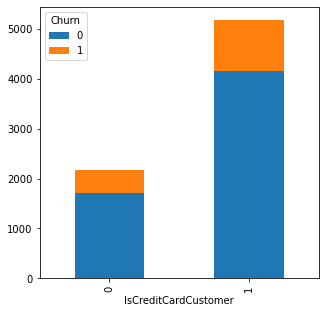

In [177]:
print(bank_data.IsCreditCardCustomer.value_counts())
ct = pd.crosstab(bank_data['IsCreditCardCustomer'], bank_data['Churn'])
ct.plot.bar(figsize = (5, 5), stacked=True)
plt.legend(title='Churn')
plt.show()

Inferenece: Churn rate is higher in customers holding credit card.

1    3757
0    3603
Name: ActiveMember, dtype: int64


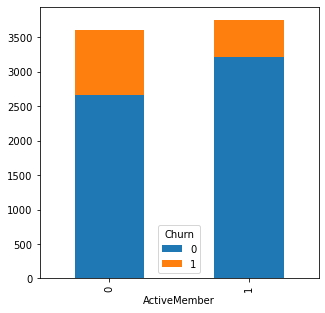

In [178]:
print(bank_data.ActiveMember.value_counts())
ct = pd.crosstab(bank_data['ActiveMember'], bank_data['Churn'])
ct.plot.bar(figsize = (5, 5), stacked=True)
plt.legend(title='Churn')
plt.show()

Inference: Inactive customers has got higher churn rate compared to active customers.

40    365
36    342
38    340
41    339
39    328
     ... 
81      2
91      1
86      1
94      1
95      1
Name: Age, Length: 70, dtype: int64


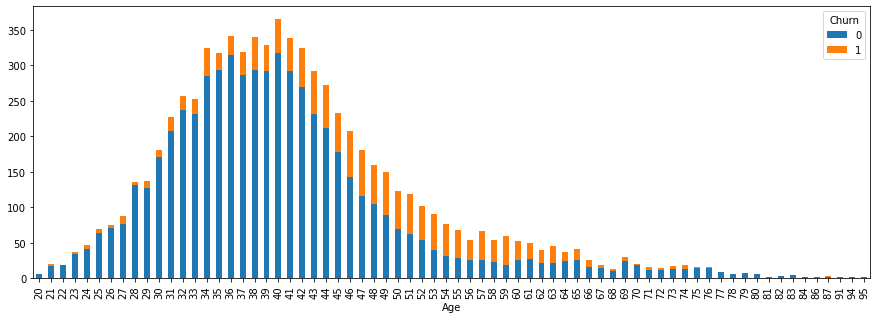

In [179]:
print(bank_data.Age.value_counts())
ct = pd.crosstab(bank_data['Age'], bank_data['Churn'])
ct.plot.bar(figsize = (15, 5), stacked=True)
plt.legend(title='Churn')
plt.show()

Inference : Large number of customers belongs to 35 - 45 years age group. Churn rate is higer with customer belonging to 34- 65 years age group.

4     789
10    782
11    739
6     728
8     728
5     727
9     724
7     722
12    571
3     496
13    214
2     140
Name: Entry_Duration, dtype: int64


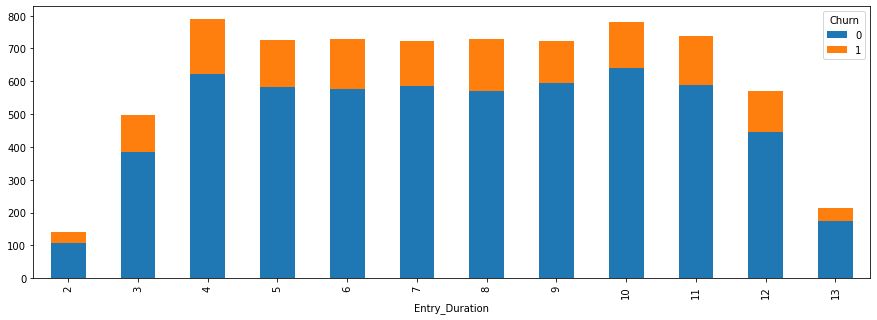

In [180]:
print(bank_data.Entry_Duration.value_counts())
ct = pd.crosstab(bank_data['Entry_Duration'], bank_data['Churn'])
ct.plot.bar(figsize = (15, 5), stacked=True)
plt.legend(title='Churn')
plt.show()

Inferenece: Majory of the customers are associated with the bank from past 3 to 12 years and thier curn rate is higher compared to new entry and oldest customer.

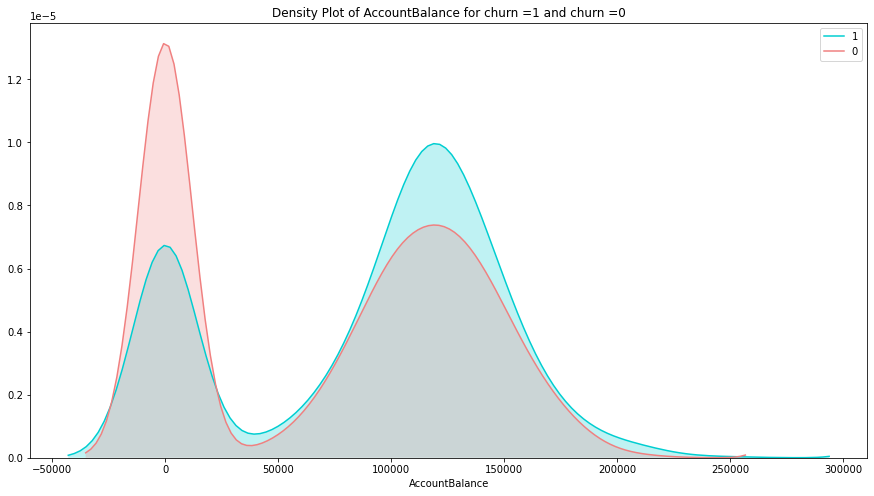

In [181]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(bank_data["AccountBalance"][bank_data.Churn == 1], color="darkturquoise", shade=True)
sns.kdeplot(bank_data["AccountBalance"][bank_data.Churn == 0], color="lightcoral", shade=True)
plt.legend(['1', '0'])
plt.title('Density Plot of AccountBalance for churn =1 and churn =0')
ax.set(xlabel='AccountBalance')
plt.show()

In [182]:
print(bank_data.AccountBalance.value_counts())

0.00         2653
105473.74       2
130170.82       2
102251.57       1
133111.73       1
             ... 
84622.13        1
114141.64       1
125961.74       1
109118.05       1
160680.41       1
Name: AccountBalance, Length: 4706, dtype: int64


Inference : Hightest churn rate are those customer having account balance between 1L to 1.5L. Amoung Customers with zero balance 2/3 would like to continue with the same bank. 

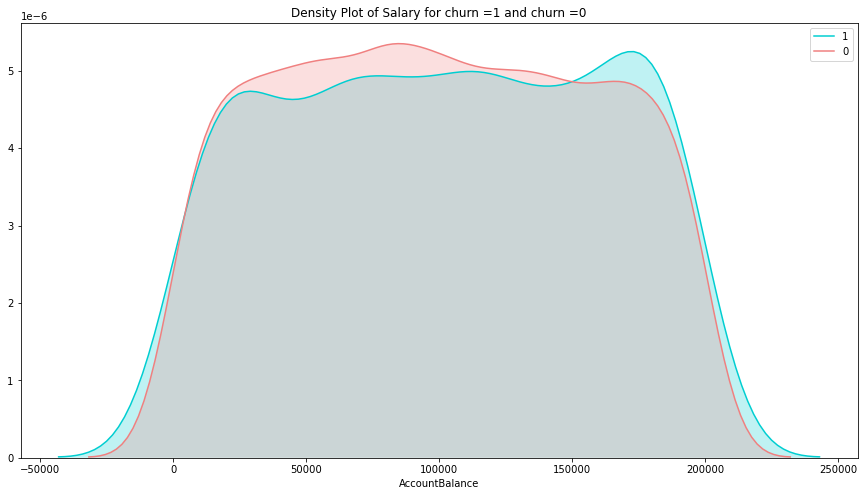

In [183]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(bank_data["Salary"][bank_data.Churn == 1], color="darkturquoise", shade=True)
sns.kdeplot(bank_data["Salary"][bank_data.Churn == 0], color="lightcoral", shade=True)
plt.legend(['1', '0'])
plt.title('Density Plot of Salary for churn =1 and churn =0')
ax.set(xlabel='AccountBalance')
plt.show()

Inference: Both the curves are almost overlapping, but Churn rate is comparitively lesser with customer having account balance leaa than 1.5Lakhs. Spike in churn rate is observed with customer having accound balance close to 1.75 Lakhs.

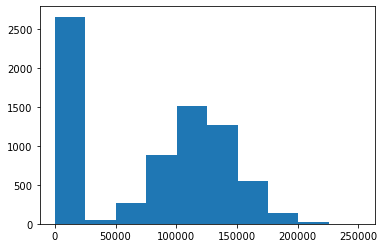

In [184]:
plt.hist(bank_data['AccountBalance'])
plt.show()

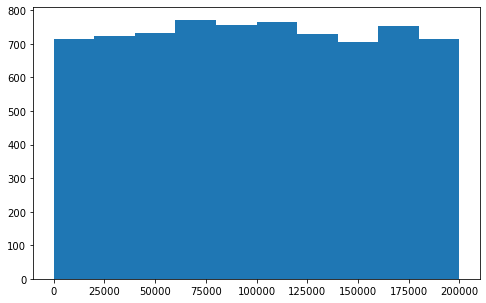

In [185]:
plt.figure(figsize=(8,5))
plt.hist(bank_data['Salary'])
plt.show()

AccountBalance and Salary are not normaly distributed hence normalize the data.

In [14]:
scaler = MinMaxScaler()
num = ['AccountBalance', 'Salary']
bank_data[num] = scaler.fit_transform(bank_data[num])

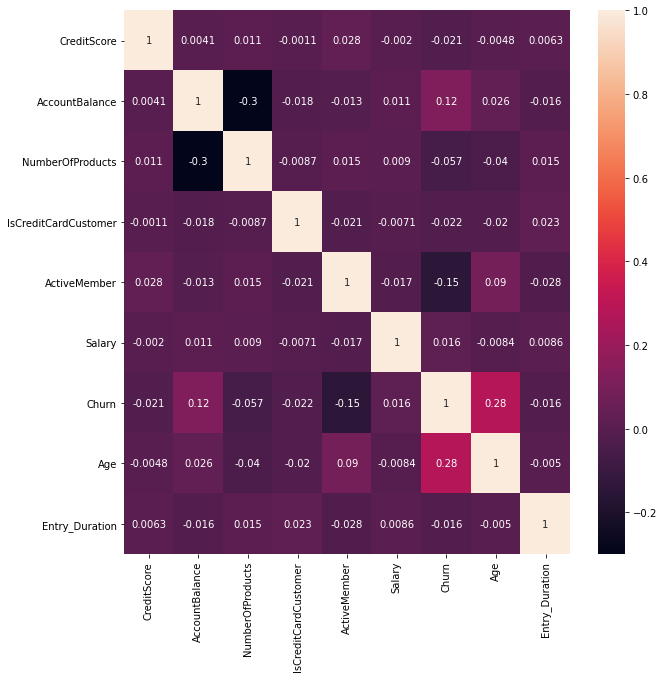

In [16]:
# Find the correclation
plt.subplots(figsize=(10, 10))
sns.heatmap(bank_data.corr(), annot=True)
plt.show()

Correlation value is less than 0.8 hence there is no strong correlation observed.

In [17]:
bank_data.dtypes

Gender                   object
Location                 object
Education                object
MaritalStatus            object
Occupation               object
Ownhouse                 object
CreditScore               int64
AccountBalance          float64
NumberOfProducts          int64
IsCreditCardCustomer      int64
ActiveMember              int64
Salary                  float64
Churn                     int64
Age                       int32
Entry_Duration            int32
dtype: object

In [18]:
colum_cat = ['Churn','Gender', 'Location', 'Education', 'MaritalStatus', 'Occupation', 'Ownhouse', 'NumberOfProducts', 'IsCreditCardCustomer', 'ActiveMember']

for col in colum_cat:
    bank_data[col] = bank_data[col].astype('category')

categorical_Attributes = bank_data.select_dtypes(include=['category']).columns

In [19]:
bank_data = pd.get_dummies(columns=categorical_Attributes, data= bank_data, 
                      prefix=categorical_Attributes, prefix_sep="_", drop_first=True)

In [20]:
bank_data.dtypes

CreditScore                   int64
AccountBalance              float64
Salary                      float64
Age                           int32
Entry_Duration                int32
Gender_Male                   uint8
Location_Location12           uint8
Location_Location13           uint8
Education_secondary           uint8
Education_tertiary            uint8
Education_unknown             uint8
MaritalStatus_married         uint8
MaritalStatus_single          uint8
Occupation_management         uint8
Occupation_retired            uint8
Occupation_self-employed      uint8
Occupation_services           uint8
Occupation_technician         uint8
Occupation_unknown            uint8
Ownhouse_unknown              uint8
Ownhouse_yes                  uint8
NumberOfProducts_2            uint8
NumberOfProducts_3            uint8
NumberOfProducts_4            uint8
IsCreditCardCustomer_1        uint8
ActiveMember_1                uint8
Churn_1                       uint8
dtype: object

In [21]:
bank_data.head()

,CreditScore,AccountBalance,Salary,Age,Entry_Duration,Gender_Male,Location_Location12,Location_Location13,Education_secondary,Education_tertiary,...,Occupation_technician,Occupation_unknown,Ownhouse_unknown,Ownhouse_yes,NumberOfProducts_2,NumberOfProducts_3,NumberOfProducts_4,IsCreditCardCustomer_1,ActiveMember_1,Churn_1
0,716,0.000000,0.948426,41,6,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,568,0.675173,0.309653,34,10,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,739,0.357716,0.965077,21,7,1,0,1,1,0,...,0,1,1,0,0,0,0,1,0,0
3,678,0.815116,0.003637,52,5,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
4,670,0.000000,0.391774,28,8,1,0,1,0,1,...,0,0,0,0,1,0,0,1,1,0


In [22]:
bank_data.rename(columns={"Churn_1": "Churn"}, inplace = True)

Spliting the data into train and test.

In [23]:
X, y = bank_data.loc[:,bank_data.columns!='Churn'].values, bank_data.loc[:,'Churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [24]:
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    4100
1    1052
dtype: int64
0    1768
1     440
dtype: int64


## Logistic regression

In [25]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.metrics import accuracy_score,classification_report, recall_score, precision_score,confusion_matrix, f1_score


In [26]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
accuracy = accuracy_score(y_test, y_pred_test)
accuracy_percentage = 100 * accuracy
accuracy_percentage

84.46557971014492

In [28]:
f1_score(y_pred_train, y_train)


0.5307599517490952

In [29]:
f1_score(y_pred_test, y_test)

0.4992700729927007

## SMOTE - Handling imbalance target variable churn

Target data is imbalance hence SMOTE is used to balance the target data

In [31]:
# import SMOTE module from imblearn library
from imblearn.over_sampling import SMOTE

In [32]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 1052
Before OverSampling, counts of label '0': 4100 

After OverSampling, the shape of train_X: (8200, 26)
After OverSampling, the shape of train_y: (8200,) 

After OverSampling, counts of label '1': 4100
After OverSampling, counts of label '0': 4100


## Retrying Logistic regression with balance data

In [33]:
log_reg.fit(X_train_res, y_train_res)
y_pred_train_res = log_reg.predict(X_train_res)
y_pred_test_res = log_reg.predict(X_test)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
accuracy = accuracy_score(y_test, y_pred_test_res)
accuracy_percentage = 100 * accuracy
accuracy_percentage

75.81521739130434

In [35]:
f1_score(y_pred_train_res, y_train_res)

0.7690243902439025

In [36]:
f1_score(y_pred_test_res, y_test)

0.5564784053156147

With balance data here are the changes
- accuracy_percentage is reduced from 84.46 to 75.81
- f1_score(y_pred_train, y_train) is increased from 0.5307 to 0.7690
- f1_score(y_pred_test, y_test) is increased from 0.4992 to 0.5564


# Decision tree

In [44]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_res, y_train_res)

In [45]:
clf.feature_importances_

array([4.92611455e-02, 7.17951201e-02, 5.56784560e-02, 1.11666918e-01,
       3.57349618e-02, 1.47456554e-02, 8.49407250e-02, 7.75837190e-03,
       7.69858938e-03, 4.96313750e-03, 7.22664791e-03, 8.19590454e-03,
       1.60053771e-02, 4.65370125e-03, 1.05691057e-03, 3.39208687e-03,
       1.02083108e-02, 5.97222718e-03, 3.35438416e-03, 2.43902439e-04,
       9.81680058e-03, 2.98425545e-01, 2.29376059e-02, 7.90629876e-03,
       1.17113525e-02, 1.44649865e-01])

In [46]:
features = bank_data.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
pd.DataFrame([bank_data.columns[indices],np.sort(importances)[::-1]])

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,NumberOfProducts_2,ActiveMember_1,Age,Location_Location12,AccountBalance,Salary,CreditScore,Entry_Duration,NumberOfProducts_3,MaritalStatus_single,...,Location_Location13,Education_secondary,Education_unknown,Occupation_technician,Education_tertiary,Occupation_management,Occupation_self-employed,Occupation_unknown,Occupation_retired,Ownhouse_unknown
1,0.298426,0.14465,0.111667,0.0849407,0.0717951,0.0556785,0.0492611,0.035735,0.0229376,0.0160054,...,0.00775837,0.00769859,0.00722665,0.00597223,0.00496314,0.0046537,0.00339209,0.00335438,0.00105691,0.000243902


In [48]:
importances

array([4.92611455e-02, 7.17951201e-02, 5.56784560e-02, 1.11666918e-01,
       3.57349618e-02, 1.47456554e-02, 8.49407250e-02, 7.75837190e-03,
       7.69858938e-03, 4.96313750e-03, 7.22664791e-03, 8.19590454e-03,
       1.60053771e-02, 4.65370125e-03, 1.05691057e-03, 3.39208687e-03,
       1.02083108e-02, 5.97222718e-03, 3.35438416e-03, 2.43902439e-04,
       9.81680058e-03, 2.98425545e-01, 2.29376059e-02, 7.90629876e-03,
       1.17113525e-02, 1.44649865e-01])

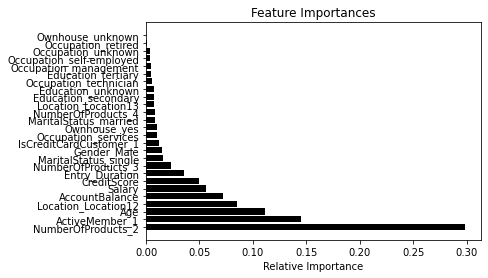

In [49]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='black')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [52]:
train_pred = clf.predict(X_train_res)
test_pred = clf.predict(X_test)

In [53]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train_res, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[4100    0]
 [   0 4100]]
[[1524  244]
 [ 228  212]]


In [54]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.8619909502262444
Test TPR:  0.4818181818181818
Test Accuracy:  0.7862318840579711


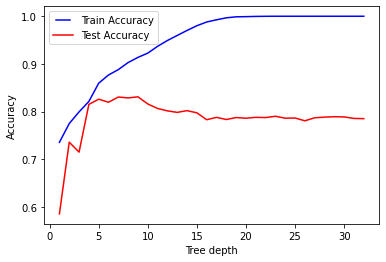

In [55]:
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
    dt = tree.DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train_res, y_train_res)
    
    train_pred = dt.predict(X_train_res)
    confusion_matrix_train = confusion_matrix(y_train_res, train_pred)
    Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
    train_results.append(Accuracy_Train)
    
    test_pred = dt.predict(X_test)
    confusion_matrix_test = confusion_matrix(y_test, test_pred)
    Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
    test_results.append(Accuracy_Test)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results,'b', label='Train Accuracy')
line2, = plt.plot(max_depths, test_results,'r', label='Test Accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()



In [56]:
param_grid = {"criterion": ["gini"],
              "min_samples_split": [2, 3],
              "max_depth": [None, 2, 5, 7],
              "min_samples_leaf": [1, 5],
              "max_leaf_nodes": [None, 5, 10],
              }

In [57]:
dt = tree.DecisionTreeClassifier()
clf2 = GridSearchCV(dt, param_grid, cv=10)
clf2.fit(X_train_res, y_train_res)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [None, 2, 5, 7],
                         'max_leaf_nodes': [None, 5, 10],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 3]})

In [58]:
clf2.best_estimator_

DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=3)

In [59]:
train_pred = clf2.predict(X_train_res)
test_pred = clf2.predict(X_test)

In [60]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train_res, train_pred)

Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Train TNR:  0.9534146341463414
Train TPR:  0.9329268292682927
Train Accuracy:  0.943170731707317
Test TNR:  0.8908371040723982
Test TPR:  0.4681818181818182
Test Accuracy:  0.8066123188405797


In [61]:
f1_score(train_pred, y_train_res)

0.9425825529817645

In [62]:
f1_score(test_pred, y_test)

0.49106078665077474

This is a overfitting scenario train accuracy is 94% where as test accuracy is 50%, hence try Random forest.

# Random forest

In [64]:
clf = RandomForestClassifier(n_estimators=10,max_depth=8)
clf.fit(X=X_train_res, y=y_train_res)

RandomForestClassifier(max_depth=8, n_estimators=10)

In [65]:

y_pred = clf.predict(X_train_res)
print("Accuracy for Train set:")
print(accuracy_score(y_train_res,y_pred))

y_pred_test = clf.predict(X_test)
print("Accuracy for Test set:")
print(accuracy_score(y_test,y_pred_test))

print("\n")

print("Recall for Train set:")
print(recall_score(y_train_res,y_pred,pos_label=1))

print("Recall for Test set:")
print(recall_score(y_test,y_pred_test,pos_label=1))

print("\n")

print("Precision for Train set:")
print(precision_score(y_train_res,y_pred,pos_label=1))

print("Precision for Test set:")
print(precision_score(y_test,y_pred_test,pos_label=1))

Accuracy for Train set:
0.9176829268292683
Accuracy for Test set:
0.8442028985507246


Recall for Train set:
0.8934146341463415
Recall for Test set:
0.5295454545454545


Precision for Train set:
0.9389900025634452
Precision for Test set:
0.6297297297297297


In [68]:
print(f1_score(y_pred, y_train_res))
print(f1_score(y_pred_test, y_test))

0.9156355455568055
0.5753086419753086


In [69]:
clf.feature_importances_

array([7.62400906e-03, 5.77894505e-02, 7.24620940e-03, 1.55798298e-01,
       8.95484693e-03, 6.81508967e-02, 1.13905557e-01, 3.24142343e-02,
       3.48284446e-03, 2.03877549e-02, 1.16855183e-02, 1.47693181e-02,
       1.70006329e-02, 4.53818817e-03, 6.88867989e-03, 4.14936981e-03,
       8.18955524e-03, 2.57585927e-03, 3.29741249e-03, 1.25518915e-04,
       2.59419550e-02, 2.50174318e-01, 2.79822756e-02, 6.61610957e-03,
       8.81497177e-03, 1.31496215e-01])

In [70]:
importances = clf.feature_importances_
indices = np.argsort(importances)
print(indices)

[19 17 18  8 15 13 23 14  2  0 16 24  4 10 11 12  9 20 22  7  1  5  6 25
  3 21]


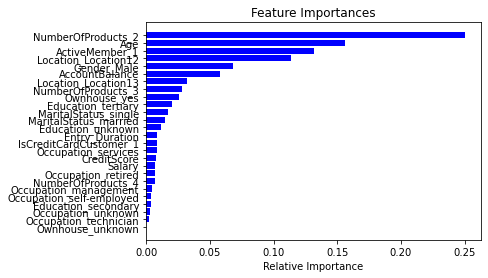

In [71]:
features = bank_data.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [72]:
from sklearn.metrics import classification_report

rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt') 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [2,3,5,7],
           "min_samples_leaf" : [2, 4]}

scores = ['precision', 'recall']

In [73]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print("\n")

    clf = GridSearchCV(estimator=rfc, param_grid=param_grid,cv=5, scoring='%s_macro' % score)
    clf.fit(X_train_res, y_train_res)

    print("Best parameters set found on training set:")
    print("\n")
    print(clf.best_params_)
    print("\n")
    
    print("Grid scores on training set:")
    print("\n")
    means = clf.cv_results_['mean_test_score']
    for mean, params in zip(means, clf.cv_results_['params']):
        print("%0.3f for %r"
              % (mean, params))

# Tuning hyper-parameters for precision


Best parameters set found on training set:


{'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 54}


Grid scores on training set:


0.829 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 9}
0.828 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 18}
0.839 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 27}
0.828 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 36}
0.833 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 45}
0.837 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 54}
0.839 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 63}
0.810 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 9}
0.824 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 18}
0.838 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 27}
0.842 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 36}
0.833 for {'max_depth': 2, 'min_samples_leaf': 4, 'n

In [74]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid,cv=5)
CV_rfc.fit(X=X_train_res, y=y_train_res)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt', n_jobs=-1),
             param_grid={'max_depth': [2, 3, 5, 7], 'min_samples_leaf': [2, 4],
                         'n_estimators': [9, 18, 27, 36, 45, 54, 63]})

In [75]:
print(CV_rfc.best_score_, CV_rfc.best_params_)

0.8889024390243904 {'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 63}


In [76]:
y_pred_train=CV_rfc.predict(X_train_res)
print(accuracy_score(y_train_res,y_pred_train))

0.906219512195122


In [77]:
y_pred_test=CV_rfc.predict(X_test)
print(accuracy_score(y_test,y_pred_test))

0.8355978260869565


In [78]:
f1_score(y_pred_train, y_train_res)

0.9029897817585468

In [79]:
f1_score(y_pred_test, y_test)

0.5479452054794521

## Feature selection

# Recursive feature elimination
Given an external estimator that assigns weights to features, recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

References:
http://scikit-learn.org/stable/modules/feature_selection.html

In [81]:
print (bank_data.columns, bank_data.shape)

Index(['CreditScore', 'AccountBalance', 'Salary', 'Age', 'Entry_Duration',
       'Gender_Male', 'Location_Location12', 'Location_Location13',
       'Education_secondary', 'Education_tertiary', 'Education_unknown',
       'MaritalStatus_married', 'MaritalStatus_single',
       'Occupation_management', 'Occupation_retired',
       'Occupation_self-employed', 'Occupation_services',
       'Occupation_technician', 'Occupation_unknown', 'Ownhouse_unknown',
       'Ownhouse_yes', 'NumberOfProducts_2', 'NumberOfProducts_3',
       'NumberOfProducts_4', 'IsCreditCardCustomer_1', 'ActiveMember_1',
       'Churn'],
      dtype='object') (7360, 27)


In [82]:
X1 = bank_data.drop(['Churn'], axis=1)

In [83]:
y1 = bank_data['Churn']

In [85]:
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 12)
rfe = rfe.fit(X1, y1)
# summarize the selection of the attributes
print('Selected features: %s' % list(X1.columns[rfe.support_]))

Selected features: ['Salary', 'Gender_Male', 'Location_Location12', 'Location_Location13', 'MaritalStatus_married', 'MaritalStatus_single', 'Occupation_retired', 'NumberOfProducts_2', 'NumberOfProducts_3', 'NumberOfProducts_4', 'IsCreditCardCustomer_1', 'ActiveMember_1']


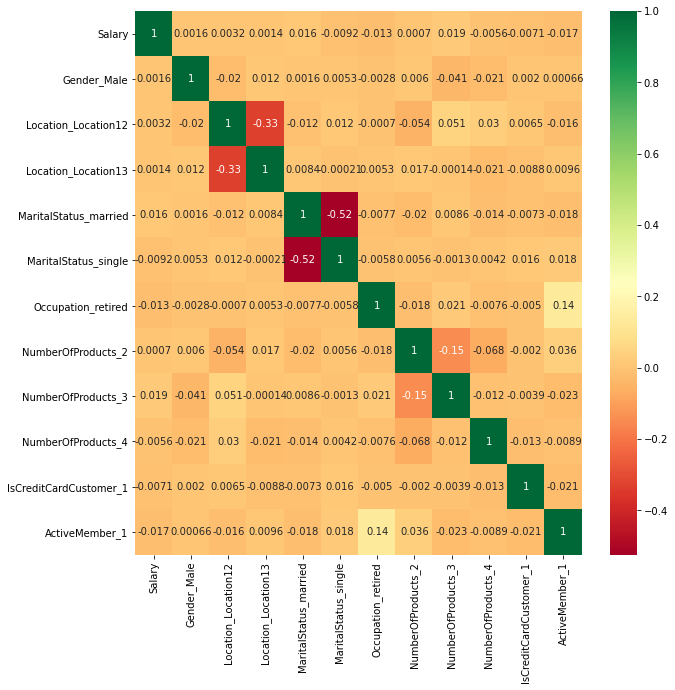

In [86]:
X_c = X1[list(X1.columns[rfe.support_])]
plt.subplots(figsize=(10, 10))
sns.heatmap(X_c.corr(), annot=True, cmap="RdYlGn")
plt.show()

Train/Test split results:
LogisticRegression accuracy is 0.685
LogisticRegression log_loss is 0.563
LogisticRegression auc is 0.781


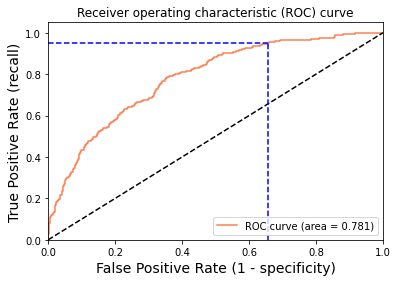

Using a threshold of 0.230 guarantees a sensitivity of 0.950 and a specificity of 0.343, i.e. a false positive rate of 65.70%.


In [89]:
X_log = X1[list(X1.columns[rfe.support_])]
y_log = y1

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=2)

sm = SMOTE(random_state = 2)
X_train_log_res, y_train_log_res = sm.fit_resample(X_train_log, y_train_log.ravel())

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train_log_res, y_train_log_res)
y_pred_log = logreg.predict(X_test_log)
y_pred_proba_log = logreg.predict_proba(X_test_log)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test_log, y_pred_proba_log)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test_log, y_pred_log))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test_log, y_pred_proba_log))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

# K Fold cross validation

In [90]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X_train_log_res, y_train_log_res, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.716 (+/-0.018)
LogisticRegression average log_loss: 0.554 (+/-0.018)
LogisticRegression average auc: 0.788 (+/-0.017)


best params: LogisticRegression(C=0.10001)
best params: {'C': 0.10001}
best score: 0.7168577934878663


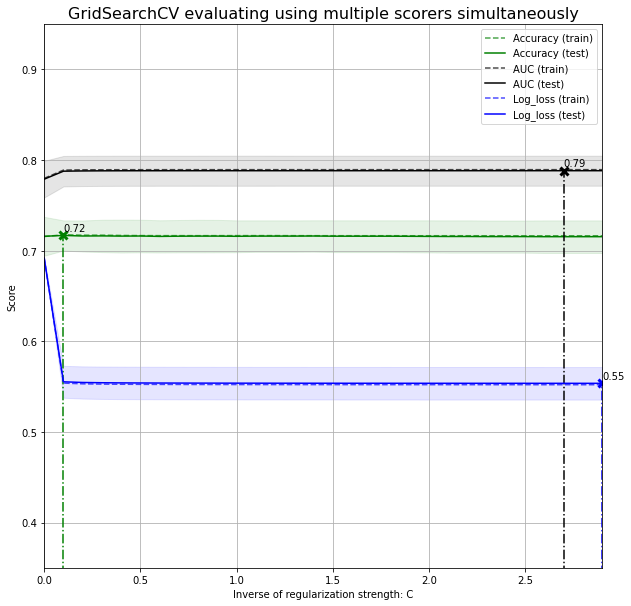

In [91]:
param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X_train_log_res, y_train_log_res)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.35, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))
    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

Feature ranking with recursive feature elimination and cross-validation RFECV performs RFE in a cross-validation loop to find the optimal number or the best number of features. Hereafter a recursive feature elimination applied on logistic regression with automatic tuning of the number of features selected with cross-validation.

Optimal number of features: 23
Selected features: ['AccountBalance', 'Salary', 'Age', 'Entry_Duration', 'Gender_Male', 'Location_Location12', 'Location_Location13', 'Education_secondary', 'Education_unknown', 'MaritalStatus_married', 'MaritalStatus_single', 'Occupation_management', 'Occupation_retired', 'Occupation_self-employed', 'Occupation_services', 'Occupation_unknown', 'Ownhouse_unknown', 'Ownhouse_yes', 'NumberOfProducts_2', 'NumberOfProducts_3', 'NumberOfProducts_4', 'IsCreditCardCustomer_1', 'ActiveMember_1']


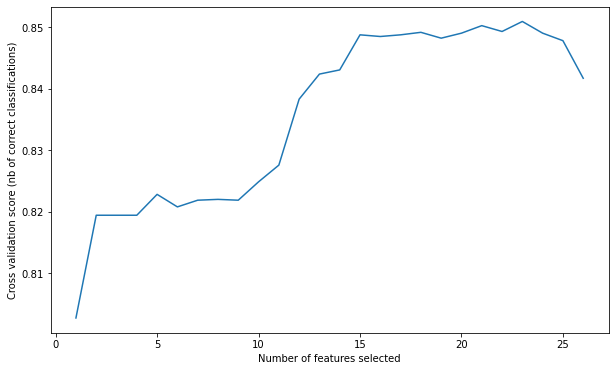

In [93]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X1, y1)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X1.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

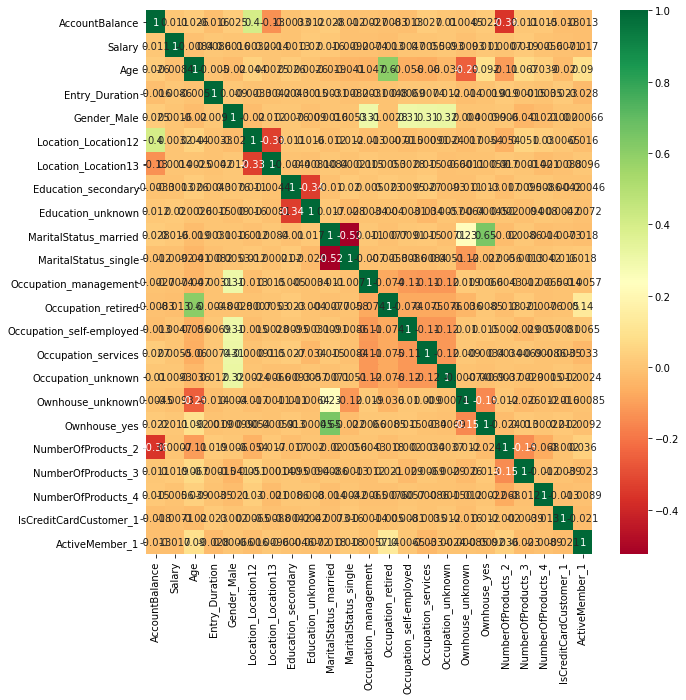

In [94]:
X_c = X1[list(X1.columns[rfecv.support_])]

plt.subplots(figsize=(10, 10))
sns.heatmap(X_c.corr(), annot=True, cmap="RdYlGn")
plt.show()

Train/Test split results:
LogisticRegression accuracy is 0.788
LogisticRegression log_loss is 0.456
LogisticRegression auc is 0.821


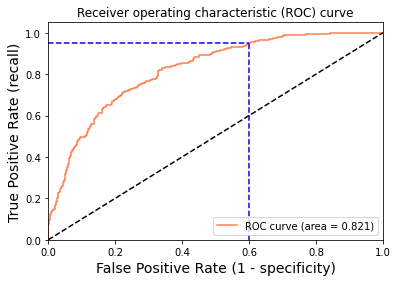

Using a threshold of 0.108 guarantees a sensitivity of 0.950 and a specificity of 0.400, i.e. a false positive rate of 59.97%.


In [95]:
X_log = X1[list(X1.columns[rfecv.support_])]
y_log = y1

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=2)

sm = SMOTE(random_state = 2)
X_train_log_res, y_train_log_res = sm.fit_resample(X_train_log, y_train_log.ravel())

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train_log_res, y_train_log_res)
y_pred_log = logreg.predict(X_test_log)
y_pred_proba_log = logreg.predict_proba(X_test_log)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test_log, y_pred_proba_log)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test_log, y_pred_log))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test_log, y_pred_proba_log))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [96]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X_train_log_res, y_train_log_res, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.816 (+/-0.052)
LogisticRegression average log_loss: 0.418 (+/-0.103)
LogisticRegression average auc: 0.893 (+/-0.053)


best params: LogisticRegression(C=1.1000100000000002)
best params: {'C': 1.1000100000000002}
best score: 0.8157130718509957


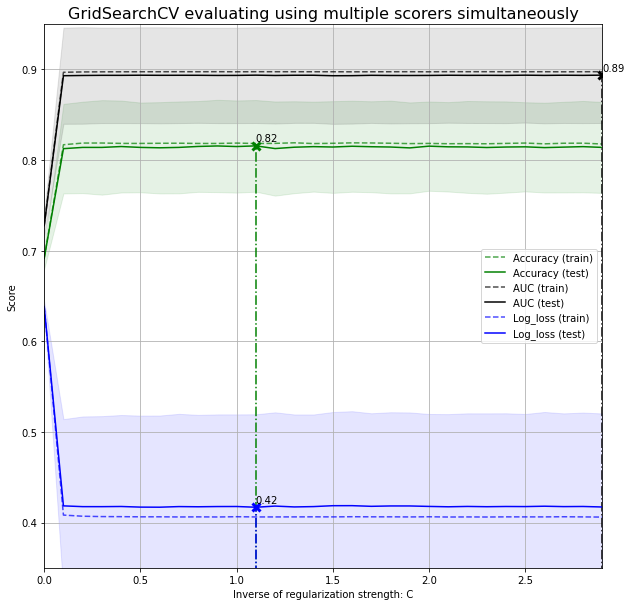

In [97]:
param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X_train_log_res, y_train_log_res)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.35, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))
    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

# Clustering

<IPython.core.display.Javascript object>


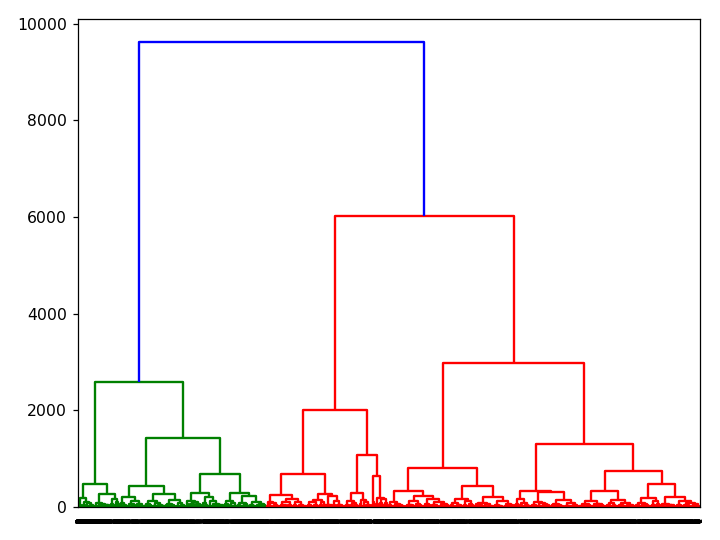

In [103]:
l_m = linkage(X_train_res, method ='ward', metric = 'euclidean')
fig, axs =plt.subplots()

In [104]:
dendrogram(l_m,labels=y_train_res)
plt.tight_layout()
plt.show()

In [105]:
from sklearn.cluster import AgglomerativeClustering
agg_c = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
agg = agg_c.fit_predict(X_train_res)

agg_r = pd.DataFrame({"label": y_train_res,"agg_cluster":agg}).sort_values('agg_cluster')

#agg_result = pd.DataFrame({"label":cereal_label,"agg_cluster":agg_clusters}).sort_values('agg_cluster')
agg_r.head()

,label,agg_cluster
0,0,0
4971,0,0
4970,0,0
4968,0,0
4966,0,0


In [106]:
agg_r.tail(20)

,label,agg_cluster
6190,1,1
6191,1,1
6192,1,1
1387,0,1
6194,1,1
4293,1,1
6197,1,1
2730,1,1
6213,1,1
4291,0,1


In [107]:
confusion_matrix_test = confusion_matrix(y_train_res, agg)
print(confusion_matrix_test)

[[2876 1224]
 [2830 1270]]


In [110]:
print(f1_score(agg, y_train_res))

0.38519866545344256


# Adaboost

In [112]:
# Create adaboost-decision tree classifer object
Adaboost_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators = 600,
    learning_rate = 1)

In [113]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 1052
Before OverSampling, counts of label '0': 4100 

After OverSampling, the shape of train_X: (8200, 26)
After OverSampling, the shape of train_y: (8200,) 

After OverSampling, counts of label '1': 4100
After OverSampling, counts of label '0': 4100


In [114]:
%time Adaboost_model.fit(X_train_res, y_train_res)
y_preds = Adaboost_model.predict(X_test)
print(accuracy_score(y_test, y_preds))

Wall time: 8.53 s
0.8034420289855072


In [115]:
param_grid = {'n_estimators' : [100, 150, 200],
              'learning_rate' : [0.1, 0.5, 0.9]}
%time
Adaboost_model_clf = GridSearchCV(AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=2)), param_grid, n_jobs=-1)

Wall time: 0 ns


In [116]:
%time Adaboost_model_clf.fit(X_train, y_train)

Wall time: 12.2 s


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2)),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 0.9],
                         'n_estimators': [100, 150, 200]})

In [117]:
%time Adaboost_model_clf.fit(X_train_res, y_train_res)

Wall time: 24.3 s


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2)),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 0.9],
                         'n_estimators': [100, 150, 200]})

In [118]:
best_ada_model = Adaboost_model_clf.best_estimator_
print (Adaboost_model_clf.best_score_, Adaboost_model_clf.best_params_) 

0.8897560975609757 {'learning_rate': 0.1, 'n_estimators': 150}


In [119]:
y_pred_test = best_ada_model.predict(X_test)

In [120]:
print(accuracy_score(y_test,y_pred_test))

0.8568840579710145


In [121]:
print(confusion_matrix(y_test, y_pred_test))

[[1698   70]
 [ 246  194]]


In [122]:
GBM_model = GradientBoostingClassifier(n_estimators=50,
                                       learning_rate=0.3,
                                       subsample=0.8)

In [123]:
%time GBM_model.fit(X=X_train_res, y=y_train_res)

Wall time: 733 ms


GradientBoostingClassifier(learning_rate=0.3, n_estimators=50, subsample=0.8)

In [124]:
y_pred = GBM_model.predict(X_test)

In [125]:
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

0.8559782608695652
              precision    recall  f1-score   support

           0     0.8812    0.9480    0.9134      1768
           1     0.6993    0.4864    0.5737       440

    accuracy                         0.8560      2208
   macro avg     0.7903    0.7172    0.7435      2208
weighted avg     0.8449    0.8560    0.8457      2208



In [126]:
# Model in use
GBM = GradientBoostingClassifier() 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [100,150],
           "max_depth" : [5, 10],
           "learning_rate" : [0.1,0.2]}
 
CV_GBM = GridSearchCV(estimator=GBM, param_grid=param_grid, cv= 5)

In [127]:
%time CV_GBM.fit(X=X_train_res, y=y_train_res)

Wall time: 3min 13s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [5, 10],
                         'n_estimators': [100, 150]})

In [128]:
# Find best model
best_gbm_model = CV_GBM.best_estimator_
print (CV_GBM.best_score_, CV_GBM.best_params_)

0.8934146341463414 {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150}


In [129]:
y_pred_test=best_gbm_model.predict(X_test)

In [130]:
print(accuracy_score(y_test,y_pred_test))

0.8419384057971014


In [131]:
print(confusion_matrix(y_test, y_pred_test))

[[1659  109]
 [ 240  200]]


In [132]:
XGB_model = XGBClassifier(n_estimators=500, gamma=0.5,learning_rate=0.1)
%time XGB_model.fit(X_train_res, y_train_res)
y_pred = XGB_model.predict(X_test)
print(accuracy_score(y_test,y_pred))

Wall time: 1.67 s
0.8469202898550725


In [133]:
XGB = XGBClassifier(n_jobs=-1)
 
# Use a grid over parameters of interest
param_grid = {
     'colsample_bytree': np.linspace(0.5, 0.9, 2),
     'n_estimators':[100],
     'max_depth': [10, 15]
}
 
CV_XGB = GridSearchCV(estimator=XGB, param_grid=param_grid, cv= 10)

In [134]:
%time CV_XGB.fit(X = X_train_res, y=y_train_res)

Wall time: 20.1 s


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, 

In [135]:
# Find best model
best_xgb_model = CV_XGB.best_estimator_
print (CV_XGB.best_score_, CV_XGB.best_params_)

0.9045121951219512 {'colsample_bytree': 0.5, 'max_depth': 10, 'n_estimators': 100}


In [136]:
y_pred_test=best_xgb_model.predict(X_test)

In [137]:
print(accuracy_score(y_test,y_pred_test))

0.8473731884057971


In [138]:
print(confusion_matrix(y_test, y_pred_test))

[[1670   98]
 [ 239  201]]


# Stacking

In [139]:
from sklearn.neighbors import KNeighborsClassifier

In [140]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train_res,y_train_res)

y_pred_train_dtc = dtc.predict(X_train_res)
y_pred_test_dtc = dtc.predict(X_test)

In [141]:
lrc = LogisticRegression()

lrc.fit(X_train_res,y_train_res)

y_pred_train_lrc = lrc.predict(X_train_res)
y_pred_test_lrc = lrc.predict(X_test)

In [142]:
knn = KNeighborsClassifier(n_neighbors=5)  

knn.fit(X_train_res, y_train_res)

y_pred_train_knn = knn.predict(X_train_res)
y_pred_test_knn = knn.predict(X_test)

In [149]:
stack_train = pd.DataFrame([y_pred_train_dtc,y_pred_train_lrc, y_pred_train_knn])
stack_test = pd.DataFrame([y_pred_test_dtc,y_pred_test_lrc, y_pred_test_knn])

In [150]:
stack_train = stack_train.T
stack_test = stack_test.T

In [152]:
stack_train.columns = ['y_pred_train_dtc','y_pred_train_lrc']
stack_test.columns = ['y_pred_test_dtc','y_pred_test_lrc', ]

In [153]:
print(stack_train.shape)
print(stack_test.shape)

(8200, 2)
(2208, 2)


In [154]:
dtc = LogisticRegression()

dtc.fit(stack_train,y_train_res)

stacked_pred_train = dtc.predict(stack_train)
stacked_pred_test = dtc.predict(stack_test)

In [155]:
from sklearn.metrics import accuracy_score, f1_score

print("TRAIN DATA ACCURACY",accuracy_score(y_train_res,stacked_pred_train))
print("\nTrain data f1-score for class '1'",f1_score(y_train_res,stacked_pred_train,pos_label=0))
print("\nTrain data f1-score for class '2'",f1_score(y_train_res,stacked_pred_train,pos_label=1))

### Test data accuracy
print("\n\n--------------------------------------\n\n")
print("TEST DATA ACCURACY",accuracy_score(y_test,stacked_pred_test))
print("\nTest data f1-score for class '1'",f1_score(y_test,stacked_pred_test,pos_label=0))
print("\nTest data f1-score for class '2'",f1_score(y_test,stacked_pred_test,pos_label=1))

TRAIN DATA ACCURACY 1.0

Train data f1-score for class '1' 1.0

Train data f1-score for class '2' 1.0


--------------------------------------


TEST DATA ACCURACY 0.78125

Test data f1-score for class '1' 0.8618025751072961

Test data f1-score for class '2' 0.4755700325732899
